In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image  

Primarily focused on data exploration and visualization for a cancer detection task. It displays sample images and provides insights into the distribution of tumor and normal labels in the training dataset.

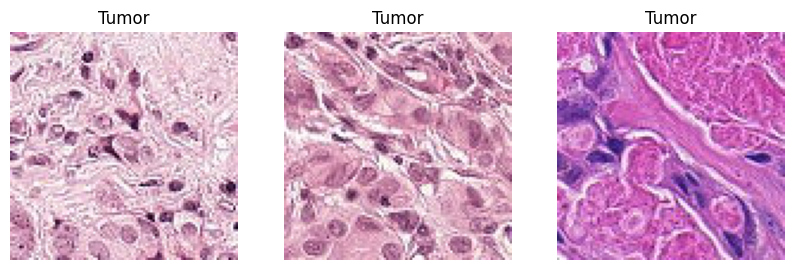

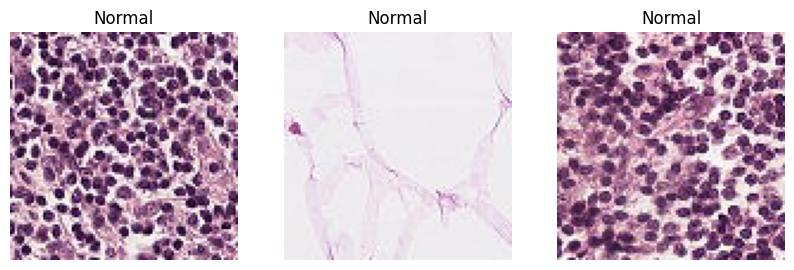

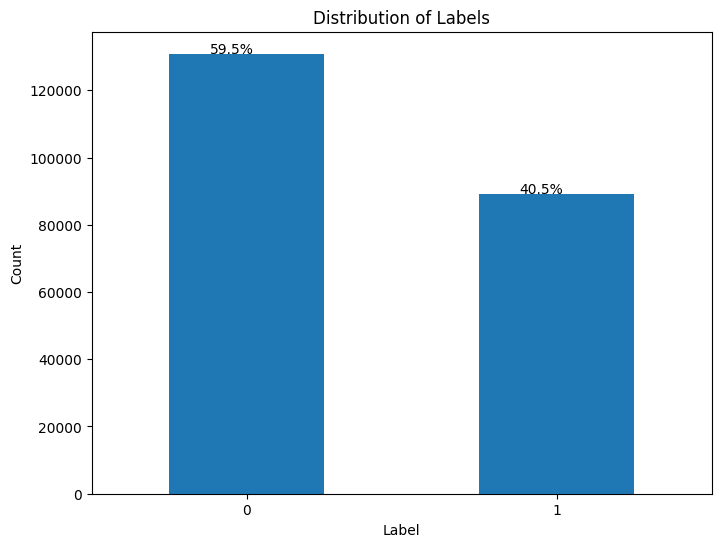

In [2]:
train_path = '/kaggle/input/histopathologic-cancer-detection/train/'
test_path = '/kaggle/input/histopathologic-cancer-detection/test/'
train_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

sample_tumor_ids = train_data[train_data['label'] == 1]['id'].sample(n=3).values
sample_normal_ids = train_data[train_data['label'] == 0]['id'].sample(n=3).values

tumor_images = []
for id in sample_tumor_ids:
    image_path = os.path.join(train_path, id + '.tif')  
    tumor_images.append(Image.open(image_path))
    
normal_images = []
for id in sample_normal_ids:
    image_path = os.path.join(train_path, id + '.tif') 
    normal_images.append(Image.open(image_path))
    
plt.figure(figsize=(10, 3))
for i, image in enumerate(tumor_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Tumor')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 3))
for i, image in enumerate(normal_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Normal')
    plt.axis('off')
plt.show()

label_counts = train_data['label'].value_counts()

plt.figure(figsize=(8, 6))
ax = label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

total = len(train_data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height() + total * 0.001
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

Splitting the train_data DataFrame into two subsets: a training set (train_data) and a validation set (val_data).

In [3]:
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

Defined a convolutional neural network (CNN) architecture for binary image classification.

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))  # Update input shape to (64, 64, 3)
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Data preparation and augmentation for training a deep learning model

In [5]:
train_data["id"] = train_data["id"].apply(lambda x: x + ".tif")
train_data["label"] = train_data["label"].astype(str)

train_data_subset = train_data.sample(frac=0.1, random_state=42)

datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data_subset,  # Use the subset
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=256,
    seed=13,
    class_mode="binary",
    target_size=(64, 64),
    shuffle=True
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data_subset,  # Use the subset
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=256,
    seed=13,
    class_mode="binary",
    target_size=(64, 64),
    shuffle=True
)

Found 14082 validated image filenames belonging to 2 classes.
Found 3520 validated image filenames belonging to 2 classes.


Training a deep learning model using the Keras framework, and it includes functionality for early stopping and model checkpointing.

In [6]:
epochs = 3

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/3
56/56 [==============================] - 154s 3s/step - loss: 0.6451 - accuracy: 0.6167 - val_loss: 0.5981 - val_accuracy: 0.6724


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/3
56/56 [==============================] - 59s 1s/step - loss: 0.5409 - accuracy: 0.7362 - val_loss: 0.4960 - val_accuracy: 0.7722
Epoch 3/3
56/56 [==============================] - 59s 1s/step - loss: 0.4910 - accuracy: 0.7712 - val_loss: 0.5544 - val_accuracy: 0.7426


Generated two side-by-side plots to visualize the training and validation performance of a deep learning model.

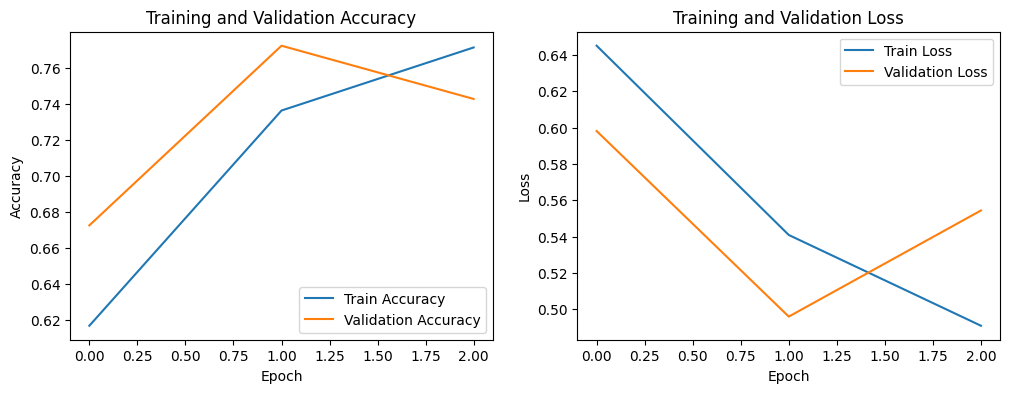

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Making predictions on a test dataset using a trained deep learning model.

In [8]:
test_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
test_data["id"] = test_data["id"].apply(lambda x: x + ".tif")

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col="id",
    y_col=None,
    class_mode=None,
    target_size=(64, 64),
    batch_size=64,
    shuffle=False
)

predictions = model.predict(test_generator)

test_data['label'] = predictions

threshold = 0.5
test_data['label'] = test_data['label'].apply(lambda x: 1 if x >= threshold else 0)

submission_path = '/kaggle/working/submission.csv'
test_data.to_csv(submission_path, columns=['id', 'label'], index=False)

test_data.head()

Found 57458 validated image filenames.
898/898 [==============================] - 575s 641ms/step


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


binary image classification problem for cancer detection. Here's a detailed explanation of the code:

Data Exploration and Visualization (Lines 8-34):

This section loads the training data, which contains image labels (1 for tumor, 0 for normal) and image IDs.
It selects random samples of tumor and normal images and displays them using Matplotlib to visualize the data.
Additionally, it creates a bar chart to visualize the distribution of tumor and normal labels in the training dataset.
Data Splitting (Line 36):

The training data is split into two subsets: a training set (train_data) and a validation set (val_data) using the train_test_split function. The validation set is used for model evaluation.
CNN Model Architecture (Lines 39-50):

Defines a Convolutional Neural Network (CNN) model for binary image classification.
The model consists of convolutional layers with ReLU activation, max-pooling layers, and fully connected (dense) layers with a sigmoid activation function for binary classification.
It compiles the model with the Adam optimizer, binary cross-entropy loss, and accuracy metric.
Data Preparation and Augmentation (Lines 53-74):

Prepares the training data for feeding into the model.
Modifies the 'id' column to include file extensions (".tif") and converts the 'label' column to string format.
Creates a data generator (train_generator) using the Keras ImageDataGenerator to perform data augmentation. It includes rescaling, horizontal and vertical flips, rotation, and zoom.
Also, creates a separate data generator (valid_generator) for the validation set.
Model Training (Lines 77-84):

Trains the CNN model using the training data generator (train_generator) for a specified number of epochs.
It includes early stopping based on validation loss to prevent overfitting and saves the best model checkpoint during training.
Training History Visualization (Lines 87-106):

Plots two side-by-side subplots to visualize the training and validation performance.
The left subplot shows the training and validation accuracy over epochs.
The right subplot shows the training and validation loss over epochs.
Test Data Prediction (Lines 109-128):

Loads the test data, which contains image IDs without labels.
Modifies the 'id' column to include file extensions (".tif").
Uses a separate data generator (test_generator) to preprocess the test data without data augmentation.
Makes predictions using the trained model on the test dataset and stores the predictions in the 'label' column.
Applies a threshold of 0.5 to classify predictions as 1 (tumor) or 0 (normal).
Submission File Creation (Lines 132-138):

Prepares a submission file in CSV format, including the 'id' and 'label' columns.
The submission file is saved as 'submission.csv' in the working directory.
Overall, this code performs various tasks related to cancer detection, including data exploration, model training, prediction on test data,